# Computing the SVD of the flow past a cylinder

In [1]:
from smartsim import Experiment
from smartredis import Client
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

plt.rcParams["figure.dpi"] = 180

In [2]:
# location of OpenFOAM case
case_name = "cylinder2D"
# number of subdomains (MPI-ranks) in the OpenFOAM simulation
mpi_ranks = 4
# function object name
fo_name = "dataToSmartRedis"
# field of which to compute the SVD
field_name = "U"

## Setting up experiment and database

In [3]:
exp = Experiment("partitioned-svd-cylinder", launcher="local")
db = exp.create_database(port=8000, interface="lo")
exp.start(db)

## Running the simulation

In [4]:
# create blockMesh
blockMesh_settings = exp.create_run_settings(exe="blockMesh", exe_args=f"-case {case_name}")
blockMesh_model = exp.create_model(name="blockMesh", run_settings=blockMesh_settings)
exp.start(blockMesh_model, summary=False, block=True) 
# create copy of original zero folder
cp_settings = exp.create_run_settings(exe="cp", exe_args=f"-r {case_name}/0.org {case_name}/0")
cp_model = exp.create_model(name="cp", run_settings=cp_settings)
exp.start(cp_model, summary=False, block=True) 
# set inlet velocity
setExp_settings = exp.create_run_settings(exe="setExprBoundaryFields", exe_args=f"-case {case_name}")
setExp_model = exp.create_model(name="setExprBoundaryFields", run_settings=setExp_settings)
exp.start(setExp_model, summary=False, block=True)
# decompose domain
decomposePar_settings = exp.create_run_settings(exe="decomposePar", exe_args=f"-case {case_name}")
decomposePar_model = exp.create_model(name="decomposePar", run_settings=decomposePar_settings)
exp.start(decomposePar_model, summary=False, block=True)
# renumber mesh cells
renumberMesh_settings = exp.create_run_settings(
    exe="renumberMesh", exe_args=f"-case {case_name} -parallel -overwrite", 
    run_command="mpirun", run_args={"np": f"{mpi_ranks}"}
)
renumberMesh_model = exp.create_model(name="renumberMesh", run_settings=renumberMesh_settings)
exp.start(renumberMesh_model, summary=False, block=True)
# run the solver
pimpleFoam_settings = exp.create_run_settings(
    exe="pimpleFoam", exe_args=f"-case {case_name} -parallel", 
    run_command="mpirun", run_args={"np": f"{mpi_ranks}"}
)
pimpleFoam_model = exp.create_model(name="pimpleFoam", run_settings=pimpleFoam_settings)
exp.start(pimpleFoam_model, summary=False, block=True)

15:47:31 andre-XP1511 SmartSim[93200] INFO blockMesh(93299): Completed
15:47:33 andre-XP1511 SmartSim[93200] INFO cp(93479): Completed
15:47:39 andre-XP1511 SmartSim[93200] INFO setExprBoundaryFields(93491): Completed
15:47:45 andre-XP1511 SmartSim[93200] INFO decomposePar(93500): Completed
15:47:51 andre-XP1511 SmartSim[93200] INFO renumberMesh(93507): Completed
15:47:58 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:03 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:08 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:13 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:18 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:23 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:28 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:33 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:48:38 andre-XP1511 SmartSim[93200] INFO pimpleFoam(93538): Running
15:4

## Connecting to the database

In [5]:
client = Client(address=db.get_address()[0], cluster=False)

SmartRedis Library@15-51-03:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@15-51-03:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO


## Computing the SVD

In [6]:
time_indices = list(range(10, 4001, 10))

In [7]:
def fetch_snapshot(time_index, mpi_rank):
    dataset_name = f"{fo_name}_time_index_{time_index}_mpi_rank_{mpi_rank}"
    if client.dataset_exists(dataset_name):
        dataset = client.get_dataset(dataset_name)
        return dataset.get_tensor(f"field_name_{field_name}_patch_internal").flatten()
    else:
        return None
    
def fetch_timeseries(time_indices, mpi_rank):
    return np.vstack([fetch_snapshot(ti, mpi_rank) for ti in time_indices]).T

In [8]:
def compute_partitioned_svd(svd_rank):
    # compute partial SVD for each MPI rank
    svd_settings = exp.create_run_settings(exe="python3", exe_args=f"partial_svd.py")
    params = {"mpi_rank" : list(range(mpi_ranks))}
    ensemble = exp.create_ensemble("svd_ensemble", params=params, run_settings=svd_settings, perm_strategy="all_perm")
    config_file = "./partial_svd.py"
    ensemble.attach_generator_files(to_configure=config_file)
    exp.generate(ensemble, overwrite=True)
    exp.start(ensemble, summary=False, block=True)
    # assemble Y matrix and compute SVD
    Y = []
    for rank_i in range(mpi_ranks):
        s = client.get_tensor(f"svd_ensemble_{rank_i}.partSVD_s_mpi_rank_{rank_i}")
        VT = client.get_tensor(f"svd_ensemble_{rank_i}.partSVD_VT_mpi_rank_{rank_i}")
        Y.append(np.diag(s) @ VT)
    Y = np.concatenate(Y, axis=0)
    Uy, sy, VTy = np.linalg.svd(Y, full_matrices=False)
    client.put_tensor("partSVD_Uy", Uy)
    client.put_tensor("partSVD_sy", sy)
    client.put_tensor("partSVD_VTy", VTy)
    # compute global left singular vectors and reconstruction
    rec_settings = exp.create_run_settings(exe="python3", exe_args=f"reconstruction.py")
    params = {
        "mpi_rank" : list(range(mpi_ranks)),
        "svd_rank" : svd_rank
    }
    ensemble = exp.create_ensemble("rec_ensemble", params=params, run_settings=rec_settings, perm_strategy="all_perm")
    config_file = "./reconstruction.py"
    ensemble.attach_generator_files(to_configure=config_file)
    exp.generate(ensemble, overwrite=True)
    exp.start(ensemble, summary=False, block=True)

In [9]:
def compute_reconstruction_error(svd_rank):
    rec = []
    for rank_i in range(mpi_ranks):
        rec_i = []
        name = f"rec_ensemble_{rank_i}.rank_{svd_rank}_field_name_{field_name}_mpi_rank_{rank_i}_"
        for i, ti in enumerate(time_indices):
            name_i = name + f"time_index_{ti}"
            rec_i.append(client.get_tensor(name_i).flatten())
        data_i = fetch_timeseries(time_indices, rank_i)
        rec_i = np.vstack(rec_i).T
        rec.append(rec_i)
    rec = np.concatenate(rec, axis=0)
    data = [fetch_timeseries(time_indices, rank_i) for rank_i in range(mpi_ranks)]
    data = np.concatenate(data, axis=0)
    return np.linalg.norm(rec - data) / np.linalg.norm(data)

In [10]:
def compute_reconstruction_error_global(svd_rank):
    data = [fetch_timeseries(time_indices, rank_i) for rank_i in range(mpi_ranks)]
    data = np.concatenate(data, axis=0)
    U, s, VT = np.linalg.svd(data, full_matrices=False)
    rec = U[:, :svd_rank] @ np.diag(s[:svd_rank]) @ VT[:svd_rank]
    return np.linalg.norm(rec - data) / np.linalg.norm(data)

In [11]:
test_ranks = (2, 4, 8, 16)
for r in test_ranks:
    compute_partitioned_svd(r)

15:51:07 andre-XP1511 SmartSim[93200] INFO svd_ensemble_0(93978): Completed
15:51:09 andre-XP1511 SmartSim[93200] INFO svd_ensemble_1(93998): Completed
15:51:09 andre-XP1511 SmartSim[93200] INFO svd_ensemble_2(94014): Completed
15:51:09 andre-XP1511 SmartSim[93200] INFO svd_ensemble_3(94034): Completed
15:51:11 andre-XP1511 SmartSim[93200] INFO rec_ensemble_0(94069): Completed
15:51:13 andre-XP1511 SmartSim[93200] INFO rec_ensemble_1(94089): Completed
15:51:13 andre-XP1511 SmartSim[93200] INFO rec_ensemble_2(94105): Completed
15:51:13 andre-XP1511 SmartSim[93200] INFO rec_ensemble_3(94125): Completed
15:51:19 andre-XP1511 SmartSim[93200] INFO svd_ensemble_0(94158): Completed
15:51:21 andre-XP1511 SmartSim[93200] INFO svd_ensemble_1(94174): Completed
15:51:21 andre-XP1511 SmartSim[93200] INFO svd_ensemble_2(94194): Completed
15:51:21 andre-XP1511 SmartSim[93200] INFO svd_ensemble_3(94214): Completed
15:51:21 andre-XP1511 SmartSim[93200] INFO svd_ensemble_1(94174): Completed
15:51:21 and

## Reconstruction error

In [12]:
part_svd_error = [compute_reconstruction_error(r) for r in test_ranks]

In [13]:
svd_error = [compute_reconstruction_error_global(r) for r in range(1, 21)]

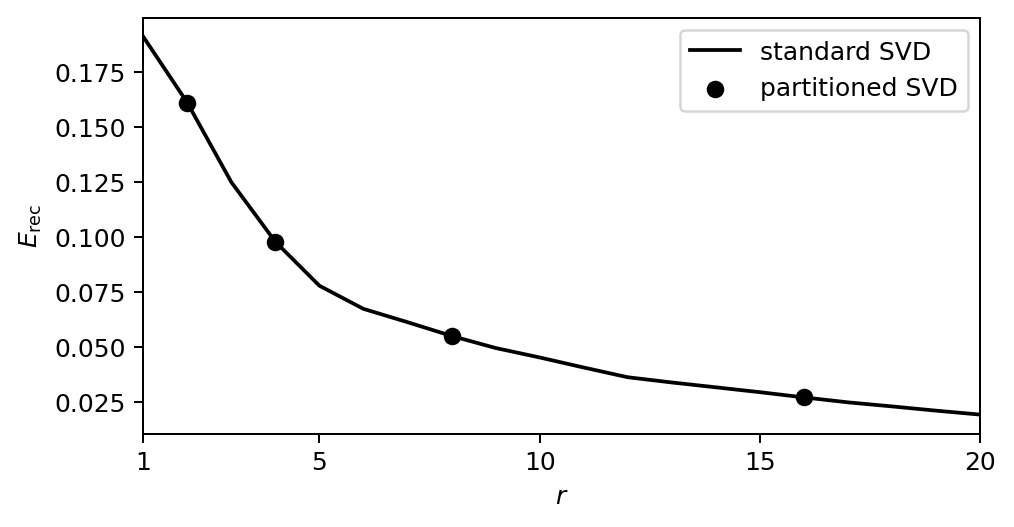

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(1, 21), svd_error, c="k", label="standard SVD")
ax.scatter(test_ranks, part_svd_error, c="k", marker="o", label="partitioned SVD")
ax.set_xticks([1, 5, 10, 15, 20])
ax.set_xlim(1, 20)
ax.legend()
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$E_\mathrm{rec}$")
plt.show()

## Transferring the data back to OpenFOAM

In [15]:
for r in test_ranks:
    settings = exp.create_run_settings(
        exe="svdToFoam",
        exe_args=f"-case {case_name} -fieldName {field_name} -svdRank {r} -FOName {fo_name} -parallel",
        run_command="mpirun", run_args={"np": f"{mpi_ranks}"}
    )

    model = exp.create_model(name="svdToFoam", run_settings=settings)
    exp.start(model, summary=False, block=True)

15:53:17 andre-XP1511 SmartSim[93200] INFO svdToFoam(94841): Completed
15:53:21 andre-XP1511 SmartSim[93200] INFO svdToFoam(94892): Completed
15:53:25 andre-XP1511 SmartSim[93200] INFO svdToFoam(94939): Completed
15:53:31 andre-XP1511 SmartSim[93200] INFO svdToFoam(94980): Completed


## Stopping the database

In [16]:
exp.stop(db)